In the last post, we have analyzed historical UFC fights and answered interesting questions like what is the most frequently used finishing technique and who won the most fights. Here, we will try to predict the outcomes of future bouts using deep learning and Python and libraries including Pandas, Numpy, and Keras. 

I have crawled over 4000 UFC fights and the career statistics of over 2000 professional fighters using Scrapy. Let's import them as well as necessary libraries.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

%matplotlib inline

Using TensorFlow backend.


In [2]:
# read data for fights and fighters
matches = pd.read_csv("ufc_matches.csv", index_col = 0)
fighters = pd.read_csv("ufc_fighters.csv")

Next, We will perform a series of steps to clean up the datasets.

In [3]:
# check if there are fighters with the same name
fighters[fighters.duplicated(subset="name", keep=False)]

,fighter_id,name,win,lose,draw,nc,height,weight,reach,stance,dob,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg,last_updated
483,483,Michael McDonald,17,4,0,0,"5' 9""",135 lbs.,"70""",Orthodox,"Jan 15, 1991",2.69,42%,2.76,57%,1.09,66%,52%,1.4,2017-12-09 13:22:27.990019
485,485,Michael McDonald,1,1,0,0,"5' 11""",205 lbs.,NaN,Orthodox,"Feb 06, 1965",0.00,0%,0.40,50%,0.00,0%,0%,0.0,2017-12-09 13:22:31.671276
800,801,Dong Hyun Kim,15,8,3,0,"5' 11""",155 lbs.,"70""",Orthodox,"Sep 09, 1988",3.50,46%,5.10,50%,2.32,60%,33%,0.0,2017-12-09 13:35:18.657568
807,808,Dong Hyun Kim,22,4,1,1,"6' 2""",170 lbs.,"76""",Southpaw,"Nov 17, 1981",2.12,49%,1.89,58%,2.93,43%,71%,0.6,2017-12-09 13:35:36.528188
895,895,Tony Johnson,11,3,0,0,"6' 1""",265 lbs.,NaN,NaN,NaN,2.00,53%,4.73,31%,2.00,22%,0%,0.0,2017-12-09 13:39:11.514317
903,903,Tony Johnson,4,2,0,0,NaN,185 lbs.,NaN,NaN,NaN,0.00,0%,0.00,0%,0.00,0%,0%,0.0,2017-12-09 13:39:29.729654


As we can see, there are several fighters with the same names. We will just need to name one of them differently.

In [4]:
# note that we got two Michael McDonalds, Dong Hyun Kims, and Tony Johnsons
# Fortunately, they belong to different weight classes
fighters.iloc[485, 1] = "Michael McDonald 205"
fighters.iloc[800, 1] = "Dong Hyun Kim 155"
fighters.iloc[903, 1] = "Tony Johnson 185"

In [5]:
# use fighter names as index
fighters.drop("fighter_id", axis=1, inplace=True)
fighters.set_index("name", inplace=True)

Some fighters do not have statistics available, so we will remove those fighters.

In [6]:
# clean up dataset, if all the eight indicators are zeros
# it means that there is no statistics for that fighter
fighers_clean = fighters.loc[~((fighters["SLpM"] == 0) &
                               (fighters["Str_Acc"] == "0%") & 
                               (fighters["SApM"] == 0) &
                               (fighters["Str_Def"] == "0%") &
                               (fighters["TD_Avg"] == 0) &
                               (fighters["TD_Acc"] == "0%") &
                               (fighters["TD_Def"] == "0%") &
                               (fighters["Sub_Avg"] == 0))].copy()                        

In [7]:
print("{0} fighers in total, after clean up: {1} fighers".format(len(fighters), len(fighers_clean)))

3009 fighers in total, after clean up: 2398 fighers


So what should we use for predictions? Here, I chose to use 9 indicators including:

* SLpM - Significant Strikes Landed per Minute
* Str_Acc - Significant Striking Accuracy
* SApM - Significant Strikes Absorbed per Minute
* Str_Def - Significant Strike Defence (the % of opponents strikes that did not land)
* TD_Avg - Average Takedowns Landed per 15 minutes
* TD_Acc - Takedown Accuracy
* TD_Def - Takedown Defense (the % of opponents TD attempts that did not land)
* Sub_Avg - Average Submissions Attempted per 15 minutes
* win% - Winning percentages

In [8]:
# add winning percentages
fighers_clean["win%"] = (fighers_clean["win"] / (fighers_clean["win"] +
                                                 fighers_clean["lose"] +
                                                 fighers_clean["draw"] +
                                                 fighers_clean["nc"]))
# change datatypes
percentages = ["Str_Acc", "Str_Def", "TD_Acc", "TD_Def"]
statistics = ["SLpM", "Str_Acc", "SApM", "Str_Def", "TD_Avg", "TD_Acc", "TD_Def", "Sub_Avg", "win%"]

fighers_clean.loc[:, percentages] = fighers_clean.loc[:, percentages].applymap(
    lambda x: x.replace("%", ""))

fighers_clean.loc[:, statistics] = fighers_clean.loc[:, statistics].astype(np.float32)

In [9]:
# remove other columns
fighers_clean = fighers_clean[statistics]

In [10]:
# make sure no missing values
fighers_clean.isnull().values.any()

False

Let's take a look at the fighters dataset that is ready to go.

In [11]:
fighers_clean.sample(10)

,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg,win%
name,,,,,,,,,
Sergio Pettis,3.62,36.0,2.56,66.0,1.09,39.0,64.0,0.5,0.842105
Mark Hunt,3.03,44.0,2.83,51.0,0.57,55.0,68.0,0.2,0.500000
Rob Emerson,2.50,30.0,2.83,64.0,2.02,52.0,65.0,0.4,0.500000
Marcelo Guimaraes,4.67,51.0,4.41,62.0,1.99,13.0,0.0,0.0,0.750000
Justin Levens,0.37,20.0,3.49,40.0,0.00,0.0,33.0,2.8,0.529412
Kenji Arai,8.79,27.0,10.29,39.0,0.00,0.0,0.0,0.0,0.428571
Frank Trigg,2.79,46.0,1.90,56.0,2.35,47.0,75.0,0.8,0.700000
Logan Clark,2.20,54.0,1.49,53.0,0.31,100.0,30.0,2.1,0.750000
Rameau Thierry Sokoudjou,2.26,45.0,2.61,56.0,1.93,47.0,78.0,0.9,0.545455


Now, let's work on the fights dataset.

In [12]:
# use matches that have a winner, ignore nc, draws
matches_clean = matches.loc[matches["result"] == "win"].copy()

# remove unnecessary columns
matches_clean = matches_clean.loc[:, ["fighter1", "fighter2", "winner", "weight_class"]]
matches_clean.reset_index(drop=True, inplace=True)

In [13]:
# note that winner is the same as figher1
matches_clean["fighter1"].equals(matches_clean["winner"])

True

In [14]:
matches_clean.head(10)

,fighter1,fighter2,winner,weight_class
0,Cub Swanson,Artem Lobov,Cub Swanson,Featherweight
1,Al Iaquinta,Diego Sanchez,Al Iaquinta,Lightweight
2,Ovince Saint Preux,Marcos Rogerio de Lima,Ovince Saint Preux,Light Heavyweight
3,John Dodson,Eddie Wineland,John Dodson,Bantamweight
4,Stevie Ray,Joe Lauzon,Stevie Ray,Lightweight
5,Mike Perry,Jake Ellenberger,Mike Perry,Welterweight
6,Thales Leites,Sam Alvey,Thales Leites,Middleweight
7,Brandon Moreno,Dustin Ortiz,Brandon Moreno,Flyweight
8,Scott Holtzman,Michael McBride,Scott Holtzman,Lightweight
9,Danielle Taylor,Jessica Penne,Danielle Taylor,Women's Strawweight


Since in the original dataset, the winner is always treated as fighter 1, we will need to randomly swap fighter1 and fighter2 for half of the dataset in order to make the predictions work.

In [15]:
# randomly swap figher1 and fighter2 for about half of the matches
swap_indices = np.random.choice(len(matches_clean), size = int(len(matches_clean) / 2), replace = False)
matches_clean.iloc[swap_indices, [0, 1]] = matches_clean.iloc[swap_indices, [1, 0]].values

In [16]:
matches_clean.head(10)

,fighter1,fighter2,winner,weight_class
0,Cub Swanson,Artem Lobov,Cub Swanson,Featherweight
1,Diego Sanchez,Al Iaquinta,Al Iaquinta,Lightweight
2,Marcos Rogerio de Lima,Ovince Saint Preux,Ovince Saint Preux,Light Heavyweight
3,Eddie Wineland,John Dodson,John Dodson,Bantamweight
4,Joe Lauzon,Stevie Ray,Stevie Ray,Lightweight
5,Mike Perry,Jake Ellenberger,Mike Perry,Welterweight
6,Sam Alvey,Thales Leites,Thales Leites,Middleweight
7,Brandon Moreno,Dustin Ortiz,Brandon Moreno,Flyweight
8,Michael McBride,Scott Holtzman,Scott Holtzman,Lightweight
9,Danielle Taylor,Jessica Penne,Danielle Taylor,Women's Strawweight


Again, handel fighters with the same names.

In [17]:
# handel duplicate names
for col in ["fighter1", "fighter2", "winner"]:
    matches_clean[col][(matches_clean[col] == "Michael McDonald") &
                       (matches_clean["weight_class"] == "Light Heavyweight")] = "Michael McDonald 205"
    
    matches_clean[col][(matches_clean[col] == "Dong Hyun Kim") &
                       (matches_clean["weight_class"] == "Lightweight")] = "Dong Hyun Kim 155"
    
    matches_clean[col][(matches_clean[col] == "Tony Johnson") &
                       (matches_clean["weight_class"] == "Middleweight")] = "Tony Johnson 185"

Continue clearning up the dataset.

In [18]:
# remove weight_class column
matches_clean.drop("weight_class", axis=1, inplace=True)

# binary results
matches_clean["result"] = (matches_clean["winner"] == matches_clean["fighter1"]).astype("int")
matches_clean.drop("winner", axis=1, inplace=True)

Next, we need to fuse these two datasets together.

In [19]:
# make sure all fighters are in the figher database
# otherwise remove the corresponding match
all_fighter_names = fighers_clean.index.values.tolist()

matches_clean = matches_clean.loc[(matches_clean["fighter1"].isin(all_fighter_names)) &
                                  (matches_clean["fighter2"].isin(all_fighter_names))].copy()

# use fighter 1 - fighter 2 (the differences) for learning
for col in statistics:
    matches_clean[col] = matches_clean.apply(
        lambda row: fighers_clean.loc[row["fighter1"], col] - fighers_clean.loc[row["fighter2"], col], axis=1)
    
# drop fighter1 and fighter2 columns
matches_clean.drop(["fighter1", "fighter2"], axis=1, inplace=True)

We will take a look at the final dataset that is going to be used for deep learning.

In [20]:
matches_clean.head()

,result,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg,win%
0,1,0.73,8.0,-1.31,13.0,0.84,27.0,2.0,0.6,0.314583
1,0,-2.20,-5.0,-0.71,-7.0,0.24,-8.0,-34.0,0.5,-0.039706
2,0,1.59,6.0,1.60,4.0,-1.23,-48.0,-26.0,0.7,-0.005682
3,0,-0.07,-13.0,0.17,6.0,-0.52,2.0,2.0,0.2,-0.050766
4,0,-0.96,-7.0,2.73,-2.0,2.05,6.0,-2.0,1.4,-0.107143


Split the dataset as train and test sets, and perform normalization.

In [21]:
# get ready for deep learning
X, y = matches_clean.iloc[:, 1:], matches_clean.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Build a neural network with 1 input layer and 5 full-connected layers, and Keras makes everything easy.

In [22]:
model = Sequential()

model.add(Dense(16, input_dim=X_train_scaled.shape[1],
                activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

We can even see a graph representation of our neural network.

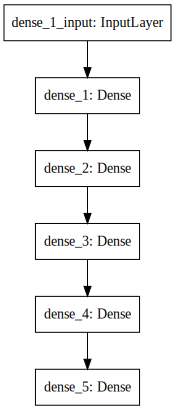

In [23]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Next, we can train the model with the training set and test it with the test set.

In [24]:
model.fit(x=X_train_scaled, y=y_train, epochs=200, batch_size=64, verbose=0)
test_results = model.evaluate(x = X_test_scaled, y = y_test, verbose=0)
print("Test Accuracy = {}".format(test_results[1]))

Test Accuracy = 0.7202881152460985


So with this model, we achieve an accuracy of 72%. Not too bad!
Now is about 7:30pm PST on Dec. 9, 2017 and there is an interesting fight between two featherweights Cub Swanson and Brian Ortega in a few hours.
Let's predict it!

In [25]:
# function for predictions
def predict(model, figher1, figher2):
    data1 = fighers_clean.loc[figher1, statistics]
    data2 = fighers_clean.loc[figher2, statistics]
    data_diff = (data1 - data2).values.reshape(1, -1)
    data_diff_scaled = scaler.transform(data_diff)
    return model.predict(data_diff_scaled)

print(predict(model, "Cub Swanson", "Brian Ortega"))

[[ 0.45191047]]


So we got a probability of 0.45, which means our model predict the fight to be very close and slightly favors Brian Ortega. Let's see what happens in a few hours!